In [10]:
from tips.io import load_ds
from tqdm.notebook import tqdm
from ase import Atoms, neighborlist
from scipy import sparse
from tips.io import load_ds
import numpy as np

In [11]:
def check_mols(mol_sets):
    """Check that the molecule scafolds are at least the same species"""
    symbs = [str(atoms[mol_set].symbols) for mol_set in mol_sets]
    cnt_mol = [symbs.count(k) for k in set(symbs)]
    return set(symbs) == set(["C2O2", "CNC2NC"])

def addADP(A, D, P, M, atoms):
    """append ADP assignment to atoms (for output)"""
    from ase import Atoms
    atoms = atoms.copy()
    numbers = np.array([10]*A.shape[0] + [11]*D.shape[0] + [12]*P.shape[0] + [13]*P.shape[0])
    positions = np.concatenate([A[:,1:], D[:,1:], P[:,0,1:], P[:,1,1:]])
    atoms += Atoms(numbers, positions=positions)
    return atoms

def atoms2adp(atoms, build_2nd=False, build_3rd=False, check=True, idx=None):
    natoms = len(atoms)
    (heavy,) = np.where(atoms.numbers != 1)
    (hydro,) = np.where(atoms.numbers == 1)
    (nitro,) = np.where(atoms.numbers == 7)
    (oxyge,) = np.where(atoms.numbers == 8)
    O_act = oxyge # all oxygen are active
    heavy2r = {k:i for i,k in enumerate(heavy)}
    
    h_rc = 6 if build_3rd else 4
    
    cutoff = {
      ("H", "C"): 2,
      ("H", "N"): h_rc,
      ("H", "O"): h_rc,
      ("C", "C"): 2,
      ("C", "N"): 2,
      ("C", "O"): 2,
    }
    
    nl_i, nl_j, nl_d = neighborlist.neighbor_list("ijd", atoms, cutoff, self_interaction=False)
    conMat = sparse.dok_matrix((natoms, natoms), dtype=np.int8)
    conMat[nl_i, nl_j] = 1  # we have several running indices here prefixed by (nl, mol, h)
    conMat[nl_j, nl_i] = 1  # v---- adapted from the ASE documentation
    
    # -- recognition of overall scafold (heavy atom networks)
    n_mol, mol_assign = sparse.csgraph.connected_components(conMat[heavy, :][:, heavy])
    
    cell = atoms.cell.diagonal()
    new_positions = atoms.positions.copy()
    for mol_i in range(n_mol):
        heavy_atoms = atoms[heavy]
        pos_mol = heavy_atoms.positions[mol_assign==mol_i]
        mass_mol = heavy_atoms.get_masses()[mol_assign==mol_i]
        pos_mol -= np.rint((pos_mol-pos_mol[:1,:])/cell[None,:])*cell[None,:]
        com_mol = mass_mol@pos_mol/(mass_mol.sum())
        pos_mol -= np.rint(com_mol/cell[None,:]-0.5)*cell[None,:]
        new_positions[heavy[mol_assign==mol_i]] = pos_mol
    atoms.set_positions(new_positions)

    mol_sets = [heavy[mol_assign == mol_i] for mol_i in range(n_mol)]
    CN_N = np.squeeze(np.asarray(conMat[nitro, :][:, heavy].sum(axis=1))) 
    N_act = nitro[CN_N==2]
    ALL_act = np.concatenate([O_act, N_act])
    mol_acts = [np.intersect1d(mol_set, ALL_act) for mol_set in mol_sets]
    if check: assert check_mols(mol_sets), str(mol_sets)
    
    # -- zeros pass, tag active protons: 
    sel0 = [np.where(nl_i == h_ia)[0] for h_ia in hydro]
    h_n0a = np.array([nl_j[_sel][np.argmin(nl_d[_sel])] for _sel in sel0])
    H_act = hydro[np.in1d(h_n0a, ALL_act)]
    if check: assert len(H_act)==32
    
    
    if not build_2nd:
        return H_act
    # -- first pass, tag D(oners)
    sel1 = [np.where(nl_i == h_ia)[0] for h_ia in H_act]
    h_n1a = np.array([nl_j[_sel][np.argmin(nl_d[_sel])] for _sel in sel1])
    h_n1e = atoms.numbers[h_n1a]
    h_n1d = np.array([nl_d[_sel][np.argmin(nl_d[_sel])] for _sel in sel1])
    D_mol = np.array([mol_assign[heavy2r[n1a]] for n1a in h_n1a])
    h_act1 = [mol_acts[_di] for _di in D_mol]
    D = np.concatenate([np.array(D_mol)[:,None], atoms.positions[h_n1a]], axis=1)
    A_mol = np.setdiff1d(np.arange(n_mol), D_mol)
    A = np.concatenate([np.array(A_mol)[:,None], [atoms.positions[mol_acts[a]].mean(axis=0)
                                                  for a in A_mol]], axis=1)
    if check and A_mol.shape[0]!=32: print(f'Double Proton Found @ {idx}')
    
    # -- second pass, make candidate neighbor for A
    sel2 = [_sel[~np.in1d(nl_j[_sel], _act)] for _sel, _act in zip(sel1, h_act1)]
    h_n2a = np.array([nl_j[_sel][np.argmin(nl_d[_sel])] for _sel in sel2])
    h_n2d = np.array([nl_d[_sel][np.argmin(nl_d[_sel])] for _sel in sel2])
    ANL = {a: [] for a in A_mol}
    for di, n2a, n2d in zip(D_mol, h_n2a, h_n2d):
        a = mol_assign[heavy2r[n2a]]
        if a in A_mol:
            ANL[a].append((di, n2d))
    
    P = [] 
    for a in A_mol:
        if ANL[a]:
            d = ANL[a][np.argmin([tmp[1] for tmp in ANL[a]])][0]
            P.append(np.concatenate([D[D_mol==d],A[A_mol==a]]))
            D = D[D_mol!=d]
            A = A[A_mol!=a]
            D_mol = D_mol[D_mol!=d]
            A_mol = A_mol[A_mol!=a]
    P = np.array(P)
    if not build_3rd:
        return A, D, P, mol_sets

atoms = traj[0]
H_act = atoms2adp(atoms, check=False)

In [77]:
ds = load_ds([
    '../trajs/cp2k/nvt-scan-20-22ps/hoac-c1im-a32b32i0-rho1.0753/cp2k-md',
    '../trajs/cp2k/nvt-scan-22-24ps/hoac-c1im-a32b32i0-rho1.0753/cp2k-md',
    '../trajs/cp2k/nvt-scan-24-26ps/hoac-c1im-a32b32i0-rho1.0753/cp2k-md',
    '../trajs/cp2k/nvt-scan-26-28ps/hoac-c1im-a32b32i0-rho1.0753/cp2k-md'],
    fmt='cp2k')

In [74]:
??load_ds

Signature: load_ds(*args, fmt='auto', **kwargs)
Docstring: <no docstring>
Source:   
def load_ds(*args, fmt='auto', **kwargs):
    if fmt in loaders:
        return loaders[fmt](*args, **kwargs)
    else:
        raise NotImplementedError(f'unknown format "{fmt}"')
File:      ~/proj_pinn/pt_pils/tips/python/tips/io/__init__.py
Type:      function


In [85]:
traj = ds[::20].convert(fmt='ase')

In [79]:
!head ../trajs/cp2k/nvt-70-80ps/hoac-c1im-a32b32i0-rho1.0753/cp2k-md-pos-1.xyz

     640
 i =   140001, time =    70000.500, E =     -2945.0358405597
  C        27.4610539126       10.2303248378        9.1851351814
  C        26.0244668774        9.9389625755        9.4461153274
  O        25.2514906522        9.4776192953        8.5855098997
  O        25.6901127964       10.4202809469       10.6732848173
  H        24.6477078699       10.6127118415       10.8152543258
  H        27.9990521897        9.6210313765        8.4413103345
  H        28.0858834327       10.3037636399       10.0916696371
  H        27.3712419161       11.1827259238        8.6141879764


In [83]:
def first_oac(atoms):
    natoms = len(atoms)
    (heavy,) = np.where(atoms.numbers != 1)
    (hydro,) = np.where(atoms.numbers == 1)
    (nitro,) = np.where(atoms.numbers == 7)
    (oxyge,) = np.where(atoms.numbers == 8)
    O_act = oxyge # all oxygen are active
    heavy2r = {k:i for i,k in enumerate(heavy)}
    h_rc = 2
    cutoff = {
      ("H", "C"): 2,
      ("H", "N"): h_rc,
      ("H", "O"): h_rc,
      ("C", "C"): 2,
      ("C", "N"): 2,
      ("C", "O"): 2,
    }
    nl_i, nl_j, nl_d = neighborlist.neighbor_list("ijd", atoms, cutoff, self_interaction=False)
    all_j = np.array(list(set(nl_j[np.in1d(nl_i,heavy[:4])])))
    return atoms[all_j]

In [86]:
oac_traj = []
for atoms in tqdm(traj):
    oac = first_oac(atoms)
    oac.center()
    oac.positions-=oac.positions[1:2,:]
    oac.positions-=np.rint(oac.positions/oac.cell[0,0])*oac.cell[0,0]
    oac.rotate(oac.positions[1]-oac.positions[0],(1,0,0))
    oac.rotate(oac.positions[3]-oac.positions[2],(0,1,0))
    oac.rotate(oac.positions[1]-oac.positions[0],(1,0,0))
    print(f'\r{len(oac)}', end='')
    oac_traj.append(oac)
write('oac.xyz', oac_traj)

  0%|          | 0/800 [00:00<?, ?it/s]

8

In [52]:
from ase.io import write


In [894]:
# traj = read('../trajs/al-adam1-sin-run1-gen31/m32i0-r1.08/asemd.traj', index='::100')
pos = []
all_pos = []
for atoms in tqdm(traj):
    cell = atoms.cell.diagonal()
    H_act = atoms2adp(atoms, check=False)
    new_pos = atoms.positions[H_act]
    if not pos:
        pos.append(new_pos)
        all_pos.append(atoms.positions)
        H_act_old = H_act
        continue
    assert (H_act == H_act_old).all()
    dpos = new_pos-pos[-1]
    dall_pos = atoms.positions-all_pos[-1]
    pos.append(pos[-1]+dpos-np.rint(dpos/cell[None,:])*cell[None,:])
    all_pos.append(all_pos[-1]+dall_pos-np.rint(dall_pos/cell[None,:])*cell[None,:])
pos = np.array(pos)
all_pos = np.array(all_pos)
com = np.einsum('tax,a->tx', all_pos, atoms.get_masses())/atoms.get_masses().sum()
pos = pos-com[:,None,:]

  0%|          | 0/100 [00:00<?, ?it/s]

/home/yunqi/.miniconda/envs/pinn-tf2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yunqi/.miniconda/envs/pinn-tf2/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


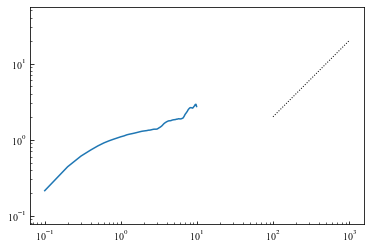

In [898]:
msd = []
maxdt = 100
for dt in range(1,maxdt+1):
    msd.append(np.mean(np.sum((pos[dt:]-pos[:-dt])**2, axis=-1)))
plt.plot(np.arange(1,maxdt+1)/10, msd)
plt.axis('equal')
plt.xscale('log')
plt.yscale('log')
d = 0.02
plt.plot([100,1000],[100*d, 1000*d], 'k:', lw=1)

In [845]:
traj = ds[::2000].convert(fmt='ase')

In [882]:
traj = read('../a_defect.traj', index='90000:100000:1000')
print(len(traj))
A_prev, D_prev, P_prev, M_prev, A_idx_prev, D_idx_prev, P_idx_prev = [None]*7
for i, atoms in enumerate(traj):
    assert (M_prev is None) or (M==M_prev), f"{M}!={M_prev}"
    A, D, P, M = atoms2adp(atoms, check=False, build_2nd=True)
    
    A_set, D_set, P_set = A[:,0], D[:,0], [set(p) for p in P[:,:,0]]
    A_idx, D_idx, P_idx = trackAD(A_set, D_set, P_set, 
                                  A_prev, D_prev, P_prev,
                                  A_idx_prev, D_idx_prev, P_idx_prev)
    
    A_prev, D_prev, P_prev, M_prev = A, D, P, M
    A_idx_prev, D_idx_prev, P_idx_prev = A_idx, D_idx, P_idx
    print(f'{i}-- A{A_idx_prev.shape[0]}, D{D_idx_prev.shape[0]}')

10
0-- A7, D3
1-- A7, D3
{60.0},{57.0, 20.0} -> {60.0, 20.0}, {57.0}
{7.0},{32.0, 3.0} -> {32.0, 7.0}, {3.0}
-{43.0, 5.0}
2-- A8, D4
{57.0},{60.0, 20.0} -> {57.0, 20.0}, {60.0}
{3.0},{32.0, 7.0} -> {32.0, 3.0}, {7.0}
+{43.0, 5.0}
3-- A7, D3
-{17.0, 47.0}
4-- A8, D4
{7.0},{32.0, 3.0} -> {32.0, 7.0}, {3.0}
+{17.0, 47.0}
5-- A7, D3
{60.0},{57.0, 20.0} -> {60.0, 20.0}, {57.0}
{38.0},{50.0, 30.0} -> {38.0, 30.0}, {50.0}
{3.0},{32.0, 7.0} -> {32.0, 3.0}, {7.0}
6-- A7, D3
{57.0},{60.0, 20.0} -> {57.0, 20.0}, {60.0}
{50.0},{38.0, 30.0} -> {50.0, 30.0}, {38.0}
-{16.0, 46.0}
7-- A8, D4
{60.0},{57.0, 20.0} -> {60.0, 20.0}, {57.0}
+{16.0, 46.0}
-{36.0, 21.0}
8-- A8, D4
{57.0},{60.0, 20.0} -> {57.0, 20.0}, {60.0}
+{36.0, 21.0}
9-- A7, D3


In [880]:
M_prev[4]

array([48, 49, 50, 51])

In [868]:
def trackAD(A_set, D_set, P_set,
            A_prev, D_prev, P_prev, 
            A_idx_prev, D_idx_prev, P_idx_prev):
    if A_prev is None:
        # make inital assignment
        A_idx = np.arange(len(A_set), dtype=int)
        D_idx = np.arange(len(D_set), dtype=int)
        P_idx = np.array([np.arange(len(A_set),len(A_set)+len(P_set), dtype=int),
                          np.arange(len(D_set),len(D_set)+len(P_set), dtype=int)]).T
        return A_idx, D_idx, P_idx
    
    A_prev, D_prev, P_prev = A_prev[:,0], D_prev[:,0], [set(p) for p in P_prev[:,:,0]]
    # convert A,D,P to sets of mols
    
    A_idx = np.zeros(len(A_set), dtype=int)
    D_idx = np.zeros(len(D_set), dtype=int)
    P_idx = np.zeros([len(P_set), 2], dtype=int)
    for i, p in enumerate(P_set):
        if p in P_prev:
            continue
            P_idx[i,:] = P_idx_prev[i,:]
        else:
            intersection = [bool(p.intersection(_p)) for _p in P_prev]
            if sum(intersection)==1:
                # XP -> PY
                p_prev = P_prev[np.where(intersection)[0][0]]
                X = p - p_prev
                Y = p_prev - p
                print(f'{X},{p_prev} -> {p}, {Y}')
            elif sum(intersection)==0:
                # P -> AD
                print(f'+{p}')
                pass
            else:
                print(A_prev, D_prev, P_prev)
                print(A_set, D_set, P_set)
                raise NotImplementedError(f'Cannot resolve the HB pair {p}') 
    for i, p in enumerate(P_prev):
        intersection = [bool(p.intersection(_p)) for _p in P_set]
        if sum(intersection)==0:
            # P -> AD
            print(f'-{p}')
    return A_idx, D_idx, P_idx

In [621]:
ds = load_ds('../trajs/al-adam1-sin-run1-gen27/nvt-340k-1ns/m0i32-r1.16/asemd.traj',fmt='asetraj', index='::1000')

In [871]:
#traj = ds.convert(fmt='ase')[:100
from ase.io import read
#traj = read('defect.traj', '::1000')  
#traj = ds[::200].convert(fmt='ase')
traj = read('../a_defect.traj', index='10000:20000:1000')
traj_labelled = [addADP(*atoms2adp(atoms, check=False, build_2nd=True), atoms) for atoms in tqdm(traj)]

  0%|          | 0/10 [00:00<?, ?it/s]

In [872]:
from ase.io import write
write('labelled.xyz', traj_labelled)

In [ ]:
from tqdm.notebook import tqdm
from ase import Atoms, neighborlist
from scipy import sparse
from tips.io import load_ds
import numpy as np


def datum2hist(datum):
    atoms = Atoms(datum["elem"], positions=datum["coord"], cell=datum["cell"], pbc=True)
    natoms = len(atoms)
    (heavy,) = np.where(atoms.numbers != 1)
    (hydro,) = np.where(atoms.numbers == 1)
    (nitro,) = np.where(atoms.numbers == 7)
    (oxyge,) = np.where(atoms.numbers == 8)
    O_act = oxyge # all oxygen are active
    heavy2r = {k:i for i,k in enumerate(heavy)}
    
    cutoff = {
      ("H", "C"): 2,
      ("H", "N"): 3,
      ("H", "O"): 3,
      ("C", "C"): 2,
      ("C", "N"): 2,
      ("C", "O"): 2,
    }
    
    
    nl_i, nl_j, nl_d = neighborlist.neighbor_list("ijd", atoms, cutoff, self_interaction=False)
    conMat = sparse.dok_matrix((natoms, natoms), dtype=np.int8)
    conMat[nl_i, nl_j] = 1  # we have several running indices here prefixed by (nl, mol, h)
    conMat[nl_j, nl_i] = 1  # v---- shamelessly taken from the ASE documentation
    
    # -- recognition of overall scafold (heavy atom networks)
    n_mol, mol_assign = sparse.csgraph.connected_components(conMat[heavy, :][:, heavy])
    mol_sets = [heavy[mol_assign == mol_i] for mol_i in range(n_mol)]
    #symbs = [str(atoms[mol_set].symbols) for mol_set in mol_sets]
    #cnt_mol = [symbs.count(k) for k in set(symbs)]
    #assert set(symbs) == set(["C2O2", "CNC2NC"]), f"broken molecules: {set(symbs)}"
    #type_mol = np.array(["N" in symb for symb in symbs], int)

    return
    
    # -- active atoms in each molecule
    CN_N = np.squeeze(np.asarray(conMat[nitro, :][:, heavy].sum(axis=1))) 
    N_act = nitro[CN_N==2]
    ALL_act = np.concatenate([O_act, N_act])
    mol_acts = [np.intersect1d(mol_set, ALL_act) for mol_set in mol_sets]
    # -- end of scafold recognition
    
    # -- recognition of HBs
    # ---- step 0: find active hydrogen
    sel0 = [np.where(nl_i == h_ia)[0] for h_ia in hydro]
    h_n0a = np.array([nl_j[_sel][np.argmin(nl_d[_sel])] for _sel in sel0])
    h_n0e = atoms.numbers[h_n0a]
    # ----- step 1: first neighbor of active hydrogen 
    H_act = hydro[(h_n0e==8) | (h_n0e==7)]
    sel1 = [np.where(nl_i == h_ia)[0] for h_ia in H_act]
    h_n1a = np.array([nl_j[_sel][np.argmin(nl_d[_sel])] for _sel in sel1])
    h_n1e = atoms.numbers[h_n1a]    
    h_n1d = np.array([nl_d[_sel][np.argmin(nl_d[_sel])] for _sel in sel1])
    h_act1 = [mol_acts[mol_assign[heavy2r[n1a]]] for n1a in h_n1a]
    # -- second neighbors
    sel2 = [_sel[~np.in1d(nl_j[_sel], _act)] for _sel, _act in zip(sel1, h_act1)]
    h_n2a = np.array([nl_j[_sel][np.argmin(nl_d[_sel])] for _sel in sel2])
    h_n2d = np.array([nl_d[_sel][np.argmin(nl_d[_sel])] for _sel in sel2])
    h_n2e = atoms.numbers[h_n2a]
    h_act2 = [np.concatenate([mol_acts[mol_assign[heavy2r[n2a]]],_act]) 
              for n2a, _act in zip(h_n2a, h_act1)]
    # -- third neighbors
    sel3 = [_sel[~np.in1d(nl_j[_sel], _act)] for _sel, _act in zip(sel2, h_act2)]
    h_n3a = np.array([nl_j[_sel][np.argmin(nl_d[_sel])] for _sel in sel3])
    h_n3d = np.array([nl_d[_sel][np.argmin(nl_d[_sel])] for _sel in sel3])
    h_n3e = atoms.numbers[h_n3a]
    h_act3 = [np.concatenate([mol_acts[mol_assign[heavy2r[n3a]]],_act]) 
              for n3a, _act in zip(h_n3a, h_act2)]
    
    # -- recognition of HB-ed specices (dimers/doners/acceptors)
    mol_state = np.zeros(n_mol)
    mol_rc = np.zeros([n_mol,2])
    mol_h = np.zeros(n_mol, int) # the active hydrogen associated with mol 
    # -- first pass assign active H to first neigh.
    for n1a in h_n1a:
        mol_state[mol_assign[heavy2r[n1a]]] += 1
    assert mol_state.max()==1
    # --- second pass, assign second neigh. to D(onor) if it is A(cceptor), this defines P(airs)
    p = []
    for h_r, (n1a, n2a, n1d, n2d) in enumerate(zip(h_n1a, h_n2a,  h_n1d,  h_n2d)):
        if ((mol_state[mol_assign[heavy2r[n1a]]]==1) and
            (mol_state[mol_assign[heavy2r[n2a]]]==0)):
            mol_state[mol_assign[heavy2r[n1a]]] = 2
            mol_state[mol_assign[heavy2r[n2a]]] = 3
            mol_rc[mol_assign[heavy2r[n1a]],:] = [n1d,n2d]
            mol_rc[mol_assign[heavy2r[n2a]],:] = [n1d,n2d]
            mol_h[mol_assign[heavy2r[n1a]]] = h_r
            mol_h[mol_assign[heavy2r[n2a]]] = h_r
            p.append(frozenset((mol_assign[heavy2r[n1a]],mol_assign[heavy2r[n2a]])))
    # --- third pass, find reaction coordinates
    rc1 = [] # D-H-P
    rc2 = [] # A-P
    rc3 = [] # D-H-P-P
    for n1a, n2a, n3a, n1d, n2d, n3d in zip(h_n1a, h_n2a, h_n3a, h_n1d, h_n2d, h_n3d):
        if ((mol_state[mol_assign[heavy2r[n1a]]]==1) and
            (mol_state[mol_assign[heavy2r[n2a]]]>=2)):
            _p1 = mol_assign[heavy2r[n2a]] # P1 is the second neighbor (mol) of the active H
            _rc_p1 = mol_rc[_p1] # rc of the target (P) species
            d1, d2 = _rc_p1.sum(), n2d+_rc_p1.min()
            rc1.append([d1, d2]) # 2d reaction coord for D-H-P reaction 
            _h2 = mol_h[_p1]
            _p2 = mol_assign[heavy2r[h_n3a[_h2]]]
            if mol_state[_p2]>=2:
                _rc_p2 = mol_rc[_p2]
                d3, d4 = _rc_p2.max()+h_n3d[_h2], _rc_p2.sum()
                rc3.append([d1-d2, d3-d4]) # 2d reaction coord for D-H-P reaction 
            
        elif ((mol_state[mol_assign[heavy2r[n1a]]]>=2) and
            (mol_state[mol_assign[heavy2r[n3a]]]==0)):
            _p1 = mol_assign[heavy2r[n2a]] # P1 is the second neighbor (mol) of the active H
            rc2.append([n1d+n2d, n1d+n3d]) # 2d reaction coord for A-P reaction
            _h2 = mol_h[_p1]
            for _p2 in np.where(np.in1d(h_n3d, h_n1a[_h2], h_n2a[_h2]))[0]:
                # one of P1's pair is P2's H's third neighbor
                print(_p2) # this rarely happens....
    a = set(np.where(mol_state==0)[0])
    d = set(np.where(mol_state==1)[0])
    p = set(p)
    return np.array(rc1), np.array(rc2), np.array(rc3), a, d, p

nbins = 200
bins = np.linspace(0,5,nbins+1)
centers = (bins[1:]+bins[:-1])/2
hist_n1d, hist_n2d, hist_n3d = np.zeros(nbins), np.zeros(nbins), np.zeros(nbins) 
hist_rc12 = np.zeros([nbins]*2)

def adp_unwrap(a_prev, d_prev, p_prev, a, d, p):
    msg = ''
    if a_prev is None:
        return a, d, p
    if p-p_prev:
        msg += f' [P+{",".join([str(tuple(_p)) for _p in  p-p_prev])}]'
    if p_prev-p:
        msg += f' [P-{",".join([str(tuple(_p)) for _p in  p_prev-p])}]'
    if a-a_prev:
        msg += f' [A+{",".join(map(str,a-a_prev))}]'
    if a_prev-a:
        msg += f' [A-{",".join(map(str,a_prev-a))}]'
    if d-d_prev:
        msg += f' [D+{",".join(map(str,d-d_prev))}]'
    if d_prev-d:
        msg += f' [D-{",".join(map(str,d_prev-d))}]'
    all_bornp = set().union(*(p-p_prev))
    all_deadp = set().union(*(p_prev-p))
    all_deadad = (a_prev.union(d_prev)-a-d)
    all_bornad = (a.union(d)-a_prev-d_prev)
    event = False
    for _p in p-p_prev: # formed pairs, try to resolve
        if _p.issubset(all_deadad): # both are from previeous a/d
            pass
        elif len(_p - all_deadp)==1: # one of the pairs is not dead, stepwise reaction
            pass
        else:
            print(_p, all_deadad)
            event = True # concerted steps, be careful!
    if msg and event:
        print(f'{idx}:{msg}')
        
    a_prev, d_prev, p_prev = a, d, p
    return a_prev, d_prev, p_prev


rc1 = np.zeros([0,2])
rc2 = np.zeros([0,2])
rc3 = np.zeros([0,2])

a_prev, d_prev, p_prev = None, None, None
for idx, datum in tqdm(enumerate(ds), total=ds.meta['size']):
    datum2hist(datum)
    pass
    # _rc1, _rc2, _rc3, a, d, p = datum2hist(datum)
    # rc1 = np.concatenate([rc1, _rc1], axis=0)
    # if len(_rc2):
    #     rc2 = np.concatenate([rc2, _rc2], axis=0)
    # if len(_rc3):
    #     rc3 = np.concatenate([rc3, _rc3], axis=0)
    # a_prev, d_prev, p_prev = adp_unwrap(a_prev, d_prev, p_prev, a, d, p)
    
    #hist_n1d += np.histogram(n1d,bins)[0]
    #hist_n2d += np.histogram(n2d,bins)[0]    
    #hist_n3d += np.histogram(n3d,bins)[0]  
    # hist_rc12 += np.histogram2d(n1d+n2d, n1d+n3d, bins)[0]


In [324]:
rc1 = rc1[:len(rc1)//2]

(0.0, 2.0)

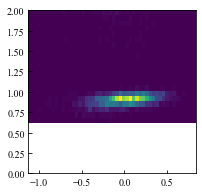

In [390]:
plt.figure(figsize=[3,3])
plt.hist2d(rc3[:,0], rc3[:,1], 50);
plt.ylim(0,2)
#plt.plot([0,6],[0,6], 'w--')

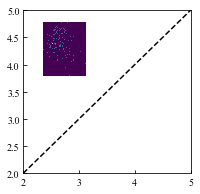

In [815]:
plt.figure(figsize=[3,3])
plt.hist2d(rc2[:,0], rc2[:,1], 50);
plt.xlim(2,5)
plt.ylim(2,5)
plt.plot([2,5],[2,5], 'k--')

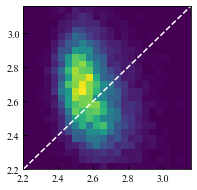

In [370]:
plt.figure(figsize=[3,3])
plt.hist2d(rc1[:,0], rc1[:,1], np.arange(2.2,3.2,0.04));
plt.plot([0,3.2],[0,3.2], 'w--')
